Import Packages

In [9]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn import preprocessing
import time
from datetime import datetime, date, time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import copy

Completed Functions

In [10]:
# CRS_ELAPSED_TIME --> HAUL_LENGTH
def haul(df, col):
    '''Determine if flight length is SHORT, MEDIUM or LONG based on expected elapsed flight time. 
            Input: 
            (0) df containing flight information, 
            (1) column containing the elapsed flight time in minutes   
            Output:   'haul_length' column determining haul length category per row in df'''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append(0) # 0 = SHORT HAUL
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append(1) # 1 = MEDIUM HAUL
        elif i >= (6*60):# 6+ hours
            length.append(2) # 2 = LONG HAUL
    df['haul_length'] = length
# example of implementation: haul(flight10k, 'crs_elapsed_time')

# CRS_DEP_TIME (hhmm) --> CRS_DEP_TIME (hh) -- to be used within time_day function
def gethour(df,col):
    '''Convert hhmm to hh (24-hr) hour-only output
            Input: 
            (0) df containing flight information, 
            (1) column containing the hhmm time                  
            Output:   rewrite on input column in rounded hh format'''
    values = []
    for i in df[col]:
        mins = (i % 100) / 60 
        hour = i // 100
        hh = round(hour+mins)
        values.append(hh)
    df[col] = values
# example of implementation: gethour(flight10k, 'crs_dep_time')

# CRS_DEP/ARR_TIME (hhmm) --> hot encoded categorical time of day 'morning, aft...' 
def time_day(df, col):
    ''' Input:
            (0) df containing flight information
            (1) corresponding column of time of flight (i.e. departure or arrival) (format hhmm)
        Output:   rewrite of time column into categorical MORNING, AFTERNOON, EVENING, or OVERNIGHT'''
    gethour(df, col)
    timeday = []
    for i in df[col]:
        if (i>=23) or (i<5):
            timeday.append(0) # 0 = OVERNIGHT
        elif (i>=5) and (i<12):
            timeday.append(1) # 1 = MORNING
        elif (i>=12) and (i<18):
            timeday.append(2) # 2 = AFTERNOON
        elif (i>=18) and (i<23):
            timeday.append(3) # 3 = EVENING
    return timeday
# example of implementation: time_day(flight10k, 'crs_dep_time')

Open CSVs of Pre-Evaluated Features

In [11]:
airline_rating = pd.read_csv('data/airline_delay_rating.csv', index_col=0)
origin_traffic = pd.read_csv('data/origin_traffic_rating.csv', index_col=0)
origin_delay = pd.read_csv('data/origin_delay_rating.csv', index_col=0)
dest_traffic = pd.read_csv('data/dest_traffic_rating.csv', index_col=0)
delay_dep_h = pd.read_csv('data/crs_dep_time_delay_rating.csv', index_col=0)
delay_arr_h = pd.read_csv('data/crs_arr_time_delay_rating.csv', index_col=0)
weather_df = pd.read_csv('data/weather_df_monthlymean_bins.csv', index_col=0)

Open CSV of Flight Information to Model

In [12]:
# This is for the dataset you want to investigate
flights = pd.read_csv('data/flights250K.csv', index_col=0)
flights.head(1)
flights.shape

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-12-26,DL,DL_CODESHARE,DL,4598,OO,N641CA,4598,13851,OKC,"Oklahoma City, OK",14869,SLC,"Salt Lake City, UT",839,830.0,-9.0,15.0,845.0,945.0,25.0,1028,1010.0,-18.0,0.0,NaN,0.0,N,169.0,160.0,120.0,1.0,866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(250000, 42)

Build df based on columns we will use in transformation - Data Cleaning and Feature Implementation

**See option A or B in first rows to build df based on training or test dataset** (for copy pasta later)

In [13]:
# A - if this is a training dataset, we need arr_delay as our target variable so use this first block of code
model_df = flights[flights['cancelled'] == 0][['arr_delay','fl_date','op_unique_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance']]
# B - if this is a testing dataset, we will not have arr_delay and cannot include it
#model_df = flights[['tail_num','op_carrier_fl_num','fl_date','op_unique_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance']]

# first regression will be simple-- is the flight going to be delayed or not?
if 'arr_delay' in model_df:
    model_df['delay_flag'] = model_df['arr_delay'].map(lambda x: 0 if x <= 0 else 1) # new target 0 or 1
    arr_delay = model_df['arr_delay'].values # to add back in later, let's store these values for us
    model_df.drop(columns='arr_delay', inplace=True) # not our current target variable anymore

# convert date to datetime in order to grab the month
model_df['fl_date'] = pd.to_datetime(model_df['fl_date'])
#model_df['year'] = model_df['fl_date'].dt.year # decided I do not want year
model_df['month'] = model_df['fl_date'].dt.month
model_df['day'] = model_df['fl_date'].dt.day
model_df['weekday'] = model_df['fl_date'].dt.dayofweek
model_df.drop(columns='fl_date', inplace=True) # this won't be needed after we got month

# join weather columns by origin and destination per each monthly average
model_df = model_df.merge(weather_df, left_on=['month','origin'], right_on=['month','airport'], how='left')
model_df.rename(columns={'mean_precip_monthly':'origin_precip_monthly','mean_snow_monthly':'origin_snow_monthly','mean_wind_monthly':'origin_wind_monthly','mean_cloud_monthly':'origin_cloud_monthly'}, inplace=True)
model_df.drop(columns='airport', inplace=True)
model_df = model_df.merge(weather_df, left_on=['month','dest'], right_on=['month','airport'], how='left')
model_df.rename(columns={'mean_precip_monthly':'dest_precip_monthly','mean_snow_monthly':'dest_snow_monthly','mean_wind_monthly':'dest_wind_monthly','mean_cloud_monthly':'dest_cloud_monthly'}, inplace=True)
model_df.drop(columns='airport', inplace=True)
model_df = model_df.fillna(0)

# set delay rating based on expected performance of the airline
model_df = model_df.merge(airline_rating, left_on='op_unique_carrier', right_on='airline', how='left')
model_df.drop(columns=['airline'],inplace=True) 

# obtain haul length of the flight using haul function defined above
haul(model_df, 'crs_elapsed_time')
# model_df.drop(columns=['crs_elapsed_time'],inplace=True)

# new column of categorical time of day information using time_day function defined above as well as expected delays relating to the time of day departure
model_df['dep_timeday'] = time_day(model_df, 'crs_dep_time')
model_df['arr_timeday'] = time_day(model_df, 'crs_arr_time')
model_df = model_df.merge(delay_dep_h, left_on='crs_dep_time', right_on='crs_dep_time', how='left')
model_df = model_df.merge(delay_arr_h, left_on='crs_arr_time', right_on='crs_arr_time', how='left')
#model_df.drop(columns=['crs_dep_time','crs_arr_time'],inplace=True)

# classify the expected traffic of the origin and departure airports
model_df = model_df.merge(origin_traffic, left_on='origin', right_on='origin', how='left')
model_df = model_df.merge(dest_traffic, left_on='dest', right_on='dest', how='left')
model_df['busy_origin'].fillna(value=model_df['busy_origin'].mean(), inplace=True)
model_df['busy_dest'].fillna(value=model_df['busy_dest'].mean(), inplace=True)
model_df = model_df.merge(origin_delay, left_on='origin', right_on='origin', how='left')
#model_df.drop(columns=['origin','dest'],inplace=True)

# currently hashed out the dropping of the raw features to test out improved correlations - to keep cat feats we need to encode
# label encode values for identification of the flight later
le = preprocessing.LabelEncoder()
model_df['op_unique_carrier'] = le.fit_transform(model_df['op_unique_carrier'].values)
model_df['origin'] = le.fit_transform(model_df['origin'].values)
model_df['dest'] = le.fit_transform(model_df['dest'].values)

# have a look at the dataset
model_df.head(10)
model_df.shape

,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,delay_flag,month,day,weekday,origin_precip_monthly,origin_snow_monthly,origin_wind_monthly,origin_cloud_monthly,dest_precip_monthly,dest_snow_monthly,dest_wind_monthly,dest_cloud_monthly,airline_delay,haul_length,dep_timeday,arr_timeday,delay_dep_h,delay_arr_h,busy_origin,busy_dest,origin_delay
0,19,253,327,9,10,169.0,866.0,0,12,26,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,1,1,0,0,3,3,1
1,24,329,331,17,18,75.0,342.0,1,4,18,3,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,2,0,2,3,3,2,3,3,1
2,24,94,316,8,10,185.0,1024.0,0,10,30,1,0.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2,1,1,1,0,0,4,4,2
3,2,93,72,7,9,99.0,331.0,0,3,9,5,0.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,2,0,1,1,0,0,3,4,2
4,19,136,238,5,6,80.0,284.0,0,3,29,4,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1,0,1,1,0,1,1,3,1
5,19,46,92,18,20,123.0,649.0,0,12,21,5,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1.0,1,0,3,3,3,3,3,4,0
6,22,167,214,17,20,142.0,758.0,0,12,1,5,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,2,0,2,3,3,3,3,3,3
7,22,310,92,14,17,140.0,853.0,0,2,8,3,1.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2,0,2,2,1,1,3,4,2
8,8,219,180,16,18,164.0,944.0,0,1,31,2,0.0,0.0,1.0,1.0,0.0,1.0,3.0,2.0,1,0,2,3,2,2,3,3,3
9,19,249,327,13,16,115.0,588.0,0,3,1,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,2,2,1,1,3,3,2


(245714, 28)

Import More Packages

In [14]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score
from sklearn import metrics

import seaborn as sns; sns.set(style='darkgrid', context='talk')
import matplotlib.pyplot as plt

Data Scaling

In [15]:
if 'delay_flag' in model_df: # training dataset
    X = model_df.drop(columns=['delay_flag'])
else: # testset
    X = model_df
y = model_df['delay_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

RobustScaler()

Random Forest Classifier for is it a delay or not? -- run in colab, took 2.25 hours for no further improvement to log reg

In [ ]:
#%%time
#tree_params = {"n_estimators": [100, 250, 500, 750, 1000],
#               'max_depth': [int(x) for x in np.linspace(1, 32, num = 5)]}
#grid_tree = GridSearchCV(RandomForestClassifier(), tree_params, cv=3, verbose=1, n_jobs=-1)
#grid_tree.fit(X_train, y_train)
#forest = grid_tree.best_estimator_
#forest.best_params_
#forest_score = cross_val_score(forest, X_train, y_train, cv=3)
#print('Random Forest Classifier Cross Validation Score: ', round(forest_score.mean() * 100, 2).astype(str) + '%')
#print("Training Score: ", round(grid_tree.best_score_,2))
#print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_tree.predict(X_test) - y_test) ** 2),2)}")

#y_forest = forest.predict(X_test)
#y_forest_proba = forest.predict_proba(X_test)
#print('\nRandom Forest Classifier - y_test')
#metrics.confusion_matrix(y_test, y_forest)
#print('AUC Score \t{:.2f}\n'.format(metrics.roc_auc_score(y_test, y_forest_proba, multi_class='ovr', average="weighted")))

Logistic Regression -- is it a delay or not?

In [16]:
import pickle

In [17]:
%%time
# Logistic Regression 
log_params = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
grid_log = GridSearchCV(LogisticRegression(solver='liblinear'), log_params, cv=5, verbose=True, n_jobs=-1)
grid_log.fit(X_train, y_train)
logreg = grid_log.best_estimator_
print(grid_log.best_params_,'\n')

print("Training R2 / Variance: ", round(grid_log.best_score_,2))
print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_log.predict(X_test) - y_test) ** 2),2)}")

y_logreg = logreg.predict(X_test)
print('\nLogistic Regression - y_test')
#print('Test R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, y_logreg)))
print('Recall \t\t{:.2f}'.format(metrics.recall_score(y_test, y_logreg)))
print('Precision \t{:.2f}'.format(metrics.precision_score(y_test, y_logreg)))
print('F1 Score \t{:.2f}'.format(metrics.f1_score(y_test, y_logreg)))
print('Accuracy \t{:.2f} <--'.format(metrics.accuracy_score(y_test, y_logreg)))
print('AUC Score \t{:.2f}\n'.format(metrics.roc_auc_score(y_test, y_logreg)))

filename = 'model1_logreg_delayornot.sav'
pickle.dump(logreg, open(filename, 'wb'))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.08858667904100823, 'penalty': 'l2'} 

Training R2 / Variance:  0.65
Residual Sum of Squares (RSS): 0.35

Logistic Regression - y_test
Recall 		0.01
Precision 	0.53
F1 Score 	0.02
Accuracy 	0.65 <--
AUC Score 	0.50

CPU times: user 4.55 s, sys: 3.61 s, total: 8.16 s
Wall time: 7min 15s


In [18]:
# load from pickle
re_logreg = pickle.load(open(filename, 'rb'))
result = re_logreg.score(X_test, y_test)
print('Re-Loaded from Pickle: ', result)

Re-Loaded from Pickle:  0.6513643855686466


Wow Pickle, you're a nice feature. Note: LogReg takes 7 minutes for 200 fits. If reloading from pickle, reminder to update logreg to re_logreg in the following cells. Re-ran this in COLAB -- also 7 minutes

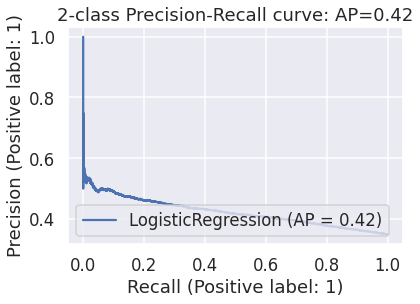

In [19]:
y_score = logreg.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score, average='micro')
from sklearn.metrics import plot_precision_recall_curve
disp = plot_precision_recall_curve(logreg, X_test, y_test);
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision));

That's unfortunate... bad recall = lacking sensitivity. Too high of false negatives -- overpredicting NON-DELAY

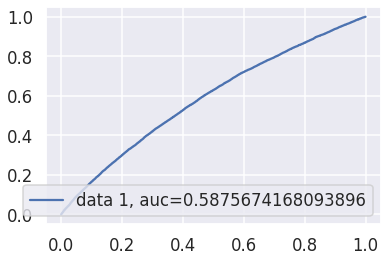

In [20]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Getting sad now that I can't even tell if it's a delay or not simply. For reference, by chance = auc of 0.5

Let's predict the entire X now so we can implement this result as a column in the model_df to progress into another model that defines 'how much' the delay will be if we were lucky enough to classify it as a delay in the first model.

In [21]:
y_logregX = logreg.predict(X)
if 'delay_pred' not in model_df: 
    model_df['delay_pred'] = y_logregX

In [24]:
model_df['arr_delay'] = arr_delay
model_df.dropna(inplace=True)

model_df.drop(columns='delay_flag', inplace=True)
delayed = model_df['delay_pred'] == 1
model_df2 = model_df[delayed]
model_df2.head(1)
model_df2.shape

,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,month,day,weekday,origin_precip_monthly,origin_snow_monthly,origin_wind_monthly,origin_cloud_monthly,dest_precip_monthly,dest_snow_monthly,dest_wind_monthly,dest_cloud_monthly,airline_delay,haul_length,dep_timeday,arr_timeday,delay_dep_h,delay_arr_h,busy_origin,busy_dest,origin_delay,delay_pred,arr_delay
0,19,253,327,9,10,169.0,866.0,12,26,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,1,1,0,0,3,3,1,1,-18.0


(245033, 29)

In [25]:
delay_bin = []
for i in model_df2['arr_delay']:
    if i <= 5:
        delay_bin.append(0) # no delay (within 5 minutes)
    elif (i > 5) and (i <= 10):
        delay_bin.append(1) # expect a 5 to 10 minute delay
    elif (i > 10) and (i <= 20):
        delay_bin.append(2) # expect a 10 to 20 minute delay
    elif (i >= 20) and  (i <= 45):
        delay_bin.append(3) # expect a 20 to 45 minute delay
    elif (i > 45):
        delay_bin.append(4) # expect a 45+ minute delay
        
model_df2['delay_range'] = delay_bin
if 'arr_delay' in model_df2:
    model_df2.drop(columns='arr_delay', inplace=True)
model_df2.head(1)
model_df2.shape
#model_df2['delay_range'].value_counts()

,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,month,day,weekday,origin_precip_monthly,origin_snow_monthly,origin_wind_monthly,origin_cloud_monthly,dest_precip_monthly,dest_snow_monthly,dest_wind_monthly,dest_cloud_monthly,airline_delay,haul_length,dep_timeday,arr_timeday,delay_dep_h,delay_arr_h,busy_origin,busy_dest,origin_delay,delay_pred,delay_range
0,19,253,327,9,10,169.0,866.0,12,26,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,1,1,0,0,3,3,1,1,0


(245033, 29)

In [26]:
# we filtered for all delay_pred==1 -- so we might as well drop this column
model_df2.drop(columns='delay_pred', inplace=True)

Second Model: Arrival Delay Range Prediction 

Data Scaling

In [27]:
if 'delay_range' in model_df2: # training dataset
    X = model_df2.drop(columns=['delay_range'])
else: # testset
    X = model_df2
y = model_df2['delay_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

RobustScaler()

Random Forest Classifier -- can we predict the predicted delay's time allotment?

In [30]:
%%time
tree_params = {"n_estimators": [100, 250, 500, 750, 1000],
               'max_depth': [int(x) for x in np.linspace(1, 32, num = 5)]}
grid_tree = GridSearchCV(RandomForestClassifier(), tree_params, cv=3, verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train)
forest = grid_tree.best_estimator_
forest.best_params_
forest_score = cross_val_score(forest, X_train, y_train, cv=3)
print('Random Forest Classifier Cross Validation Score: ', round(forest_score.mean() * 100, 2).astype(str) + '%')
print("Training Score: ", round(grid_tree.best_score_,2))

filename = 'model2_randforest_delayrange.sav'
pickle.dump(logreg, open(filename, 'wb'))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


exception calling callback for <Future at 0x7f8c816b9f10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/robyn/anaconda3/envs/LHL_Bootcamp/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/robyn/anaconda3/envs/LHL_Bootcamp/lib/python3.7/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/robyn/anaconda3/envs/LHL_Bootcamp/lib/python3.7/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/robyn/anaconda3/envs/LHL_Bootcamp/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/robyn/anaconda3/envs/LHL_Bootcamp/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/robyn/anaconda3/envs/

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11), SIGSEGV(-11)}

Note for RandomForestClassifier: 75 fits ran for ... minutes -- it was cpu terminated on my computer many times.  :( 

I've run it in colab now which will be saved to git under the same name + COLAB FINAL

In [ ]:
# load from pickle
re_forest = pickle.load(open(filename, 'rb'))
result = re_forest.score(X_test, y_test)
print('Re-Loaded from Pickle: ', result)

In [ ]:
y_forest = forest.predict(X_test)
y_forest_proba = forest.predict_proba(X_test)
print('\nRandom Forest Classifier - y_test')
metrics.confusion_matrix(y_test, y_forest)
print('AUC Score \t{:.2f}\n'.format(metrics.roc_auc_score(y_test, y_forest_proba, multi_class='ovr', average="weighted")))